# Including epistemic uncertainties in engineering decision making

**ICASP 14 - paper 68**

This notebook develops the synthetic model that is used as part of the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns
from scipy.optimize import fsolve

from potanalysis import clust, autocorr, MRL, TC, diagnostic_plots, ecdf
from potanalysis import bayesian_diagnostic_plots
from mh_posterior import mh_paths_sampler, paths_diagnostics

# Plotting parameters
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams.update({'font.size': 7, 'lines.linewidth':0.8, 'axes.linewidth':0.5,
                     'xtick.major.width':0.5, 'ytick.major.width':0.5})

## Recurrence model for discharges

Load and clean dataset. The dataset was obtained from the UK National River Flow Archive.

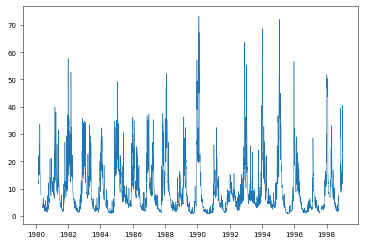

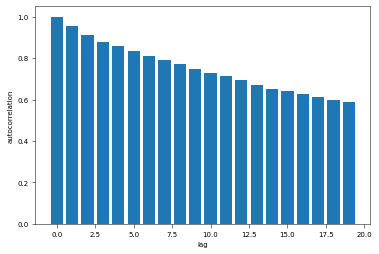

In [2]:
# Read discharge data
filename = 'data\\Buscot-daily_discharge.csv'
df = pd.read_csv( filename, usecols=[0,1], skiprows=19, parse_dates=[0] )

# Add 'time' and 'obs' index columns
df['obs'] = df['discharge']
df['time'] = np.arange( 0, len(df), 1 )

# Fill NaN values with interpolation
df0 = df.interpolate('linear')

# Plot time series
fig, ax = plt.subplots()
ax.plot( df['date'], df['discharge'], linewidth=0.5 )

# Autocorrelation of the series
acf, ax = autocorr( df['discharge'], plot=True );

### POT model

c:\Users\maria\OneDrive - fi.uba.ar\PhD\Reports\ICASP 14\paper id68\icasp14_paper68\potanalysis.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['dt'] = np.append( 0, np.diff( dfu['time'] ) )


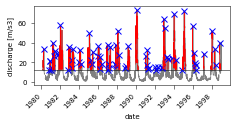

In [3]:
# Fit GPD to exceedance points with selected threshold u
u = 12 # Threshold

# Clustering
df_cl, ax_clust = clust( df, u=u, time_cond=7, clust_max=True, plot=True)

# Plotting
fig = ax_clust.figure
qu = df_cl['obs'][ df_cl['obs']>u ] - u
fig.tight_layout()

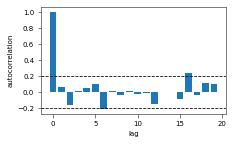

In [4]:
# Autocorrelatio of the threshold exceedances
acf, ax = autocorr( qu, plot=True )
ax.figure.set_size_inches(8.4/2.54, 5/2.54)
ax.axhline( y=0.2, color='k', linestyle='--')
ax.axhline( y=-0.2, color='k', linestyle='--')
fig.tight_layout()

### Mean rate & interarrival times

The mean rate $\lambda_0$ is computed from threshold exceedances as $n/T$, where $n$ is the number of extreme events and $T$ the time span of data.

According to standard POT theory, the time between occurrences of extreme events should follow an exponential distribution.

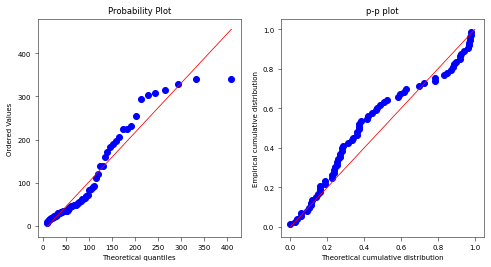

In [5]:
# Mean recurrence interval
ti = np.diff( df_cl.time )
n = len(qu) # Events occurred
T = len(df)/365 # Total time in years
m_mean = n/T

# Check exponential distribution of interarrival times
distr = st.expon
ti_params = distr.fit( ti )
_ = diagnostic_plots( ti, distr, ti_params );

### Distribution for threshold exceedances (GPD)

The exceedances above threshold $u$ are modelled by a GPD, following the standard extreme value theory. The prior distributions of the parameters are Gaussian, centered at the MLE obtained by classical optimization techniques, and with a large variance to represent non-informativenesss.

$$
\begin{aligned}
\mathbf{y} | \xi, \sigma &= \prod_{i}  \frac{1}{\sigma} \left( 1 + \xi \frac{y_i-u}{\sigma}\right)^{-\frac{1}{\xi} - 1}\\
\xi &\sim \mathcal{N} \left( \hat{\xi}, 10\cdot\hat{\xi}\right)\\
\sigma &\sim \mathcal{N} \left( \hat{\sigma}, 10 \cdot \hat{\sigma} \right)
\end{aligned}
$$

Maximum Likelihood estimates as in standard classical statistics

In [6]:
# MLE estimates of the parameters
t_mle = st.genpareto.fit( qu, floc=0 )

Bayesian posterior estimates of the parameters usnig MCMC

Starting path 1 of 4


c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Starting path 2 of 4
Starting path 3 of 4
Starting path 4 of 4


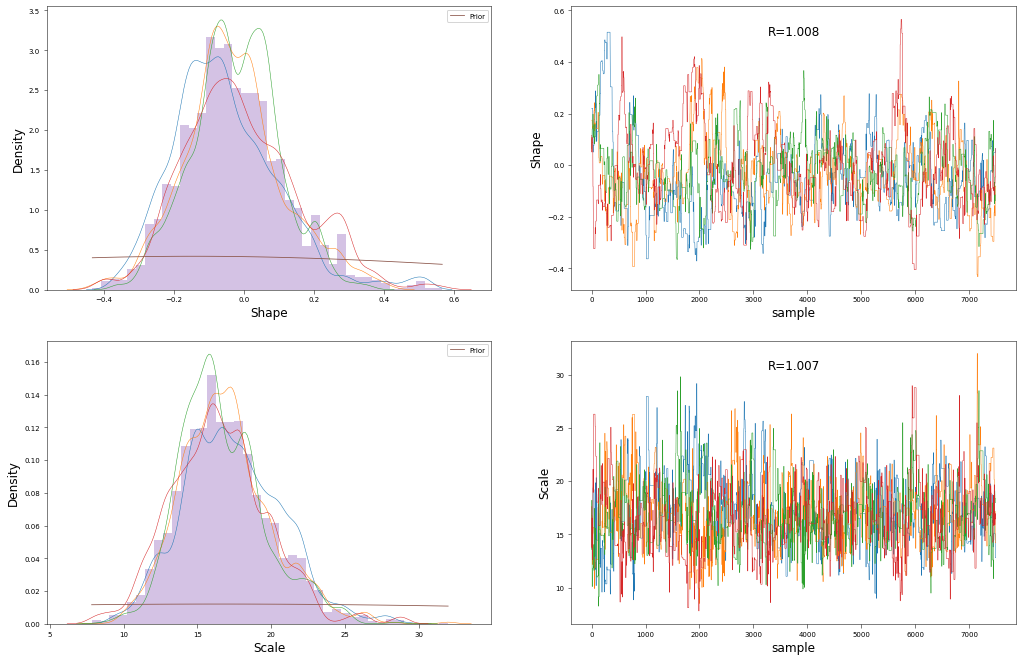

In [8]:
# Priors (Jeffrey's prior from)
logPrior = lambda t: -np.log(t[1]) - np.log(1+t[0]) - 1/2*np.log(1+2*t[0])
t1_prior = st.norm( loc=3*t_mle[0], scale=np.abs(t_mle[0]*20) )
t2_prior = st.norm( loc=t_mle[2], scale=np.abs(t_mle[2]*2) )
logpriors = [t1_prior, t2_prior]

# Log-likelihood
logLikelihood = lambda t: sum( st.genpareto.logpdf(qu, t[0], loc=0, scale=t[1]) )
# Posterior
target_logpdf = lambda t: logLikelihood( t ) + logPrior( t )

# MCMC
Npaths = 4; Nsim = 15000; burnin = int(Nsim/2+1)
x0 = np.random.uniform( [-0.2,14], [0.2,20], [Npaths+1,2] )
sigmas = np.array([t_mle[0]*1.5, t_mle[2]*1.5])
cov = sigmas**2*np.eye(len(sigmas))
Xbin, Xstack, acceptance, _ = mh_paths_sampler(target_logpdf, Npaths, 
                                               Nsim, x0, cov,
                                               burnin=burnin, thin=1,
                                               sampler='adaptive', tune=2000,
                                               tune_intvl=8000,
                                               proposal=None)
# MCMC convergence diagnostics
R, var_j, rhot, neff = paths_diagnostics( Xbin, True, *logpriors )

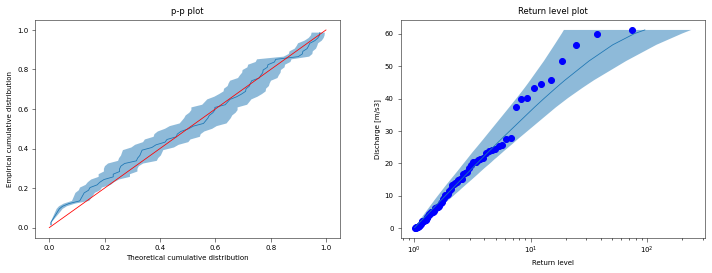

In [9]:
# Fit diagnostics
qFi, qTri, fig = bayesian_diagnostic_plots( qu, st.genpareto, Xstack, conf=0.9 );

Plots for paper

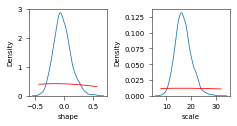

In [10]:
fig, ax = plt.subplots( figsize=(8.4/2.54,4.5/2.54), ncols=2 )
sns.kdeplot( Xstack[:,0], fill=False, ax=ax[0], label='posterior', bw_adjust=2 )
shape_x = np.linspace( Xstack[:,0].min(), Xstack[:,0].max(), 1000 )
ax[0].plot( shape_x, t1_prior.pdf( shape_x ), color='r', label='prior' )
ax[0].set_xlabel('shape')
# ax[0].axvline( t_mle[0], color='k', linestyle='--', linewidth=.5 )
sns.kdeplot( Xstack[:,1], fill=False, ax=ax[1], bw_adjust=1.8 )
scale_x = np.linspace( Xstack[:,1].min(), Xstack[:,1].max(), 1000 )
ax[1].plot( scale_x, t2_prior.pdf( scale_x ), color='r' )
ax[1].set_xlabel('scale')
# ax[1].axvline( t_mle[-1], color='k', linestyle='--', linewidth=.5 )
# ax[0].legend()
fig.tight_layout()

### Posterior predictions

Posterior CDF for discharges

In [11]:
# Number of distribution curves
N = 1000

# Simulate GPD
indices = np.random.choice( Xstack.shape[0], size=N )
x_plot = np.arange(0.1,150,0.1)
Tr_plot = np.arange(0.2,500,0.1)
Fi = np.zeros( [len(x_plot), N] )
Fi_mle = np.zeros( [len(x_plot), N] )
zTri = np.zeros( [len(Tr_plot), N] )
rQ = np.zeros( N )
for i in range( N ):
    t = Xstack[indices[i],:]
    # MLE
    Fi_mle[:,i] = st.genpareto.cdf( x_plot, *t_mle )
    # approach 2
    zTri[:,i] = u + st.genpareto.ppf( (1-1/Tr_plot/m_mean), t[0], loc=0, scale=t[1] )

# Return levels for discharges
Fi_emp = ecdf( qu + u )[1]
pannual_emp = (1 - Fi_emp) * m_mean
# MLE
pannuali = (1-Fi_mle)*m_mean
qi = (1 - 0.9)/2; qs = (1 + 0.9)/2
pannual_ci_mle = np.quantile( pannuali, [qi,qs], axis=1) 
pannual_mean_mle = np.mean( pannuali, axis=1 )
# Approach 2
x_Tr_ci = np.quantile( zTri, [qi,qs], axis=1) 
x_Tr_mean = np.mean( zTri, axis=1 )

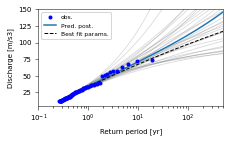

In [12]:
# Plot
fig, ax = plt.subplots( figsize=(8.4/2.54,4.5/2.54) )

# X MODEL PLOT
ax.plot( 1/pannual_emp, np.sort(qu)+u, 'bo', markersize=3, label='obs.', zorder=10 )
ax.plot( Tr_plot, zTri[:,:30], color='gray', alpha=.3 )
ax.plot( Tr_plot, x_Tr_mean, label='Pred. post.', linewidth=1.5 )
ax.plot( 1/pannual_mean_mle, x_plot+u, label='Best fit params.', linewidth=1,
            color='k', linestyle='--' )
ax.set_xlabel( 'Return period [yr]' )
ax.set_ylabel( 'Discharge [m/s3]' )
ax.set_xlim([0.1,500])
ax.set_ylim([5,150])
ax.set_xscale('log')
ax.legend( loc='best', fontsize=6 );
# sns.kdeplot( rbeta[:,0], ax=ax[0])
# ax[0].axvline( beta_max[0], color='k', linestyle='--' )
# ax[0].axvline( rbeta[:,0].mean(), color='r', linestyle='--' )

## Flow model

A synthetic model was used for the flow model $Z=g(X,\beta)$ where $\beta$ are parameters of the computational model

In [13]:
# Auxiliar funciton to find Skew Normal distribution parameters from mode and std
def SNstats( loc, scale, a ):
    delta = a / np.sqrt(1+a**2)
    gamma1 = (4-np.pi)/2 * (delta*np.sqrt(2/np.pi))**3 / (1-2*delta**2/np.pi)**(3/2)
    meanz = np.sqrt(2/np.pi) * delta
    sigmaz = np.sqrt(1-meanz**2)
    
    modeSN = loc + scale * (meanz - gamma1*sigmaz/2 - np.sign(a)/2*np.exp(-2*np.pi/np.abs(a)) )
    meanSN = loc + scale*delta*np.sqrt(2/np.pi)
    sigmaSN = scale * np.sqrt( 1 - 2*delta**2/np.pi )
    
    return meanSN, sigmaSN, modeSN

def myfunction( x, *args ):
    mode, sigma, a = args
    meanSN, sigmaSN, modeSN = SNstats( x[0], x[1], a )
    F = np.empty((2))
    F[0] = modeSN - mode
    F[1] = sigmaSN - sigma
    return F

In [23]:
# Computational model
computationalModel = lambda x, beta: (beta * x) * 0.1 # linear
# computationalModel = lambda x, beta: (-20 + 160*(1-np.exp(-(beta * x)/35))) * 0.1 # non-linear

# Parameters posterior distribution
beta_mode = 1 # mode
N = 1000
a = 0 # skew
sigma = 0.2
pSN = fsolve( myfunction, x0=(beta_mode,sigma), args=(beta_mode,sigma,a) )
dbeta = st.skewnorm( loc=pSN[0], scale=pSN[1], a=a )
rbeta = dbeta.rvs(size=N)

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Plot for paper

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


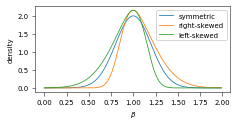

In [24]:
# Plot
beta_plot = np.arange( 0, 2, 0.01 )
fig, ax = plt.subplots( figsize=(8.4/2.54,4.5/2.54) )
# sym
pSN = fsolve( myfunction, x0=(beta_mode,sigma), args=(beta_mode,sigma,0) )
dbeta_aux = st.skewnorm( loc=pSN[0], scale=pSN[1], a=0 )
ax.plot( beta_plot, dbeta_aux.pdf( beta_plot ), label='symmetric' )
# skew right
pSN = fsolve( myfunction, x0=(beta_mode,sigma), args=(beta_mode,sigma,3) )
dbeta_aux = st.skewnorm( loc=pSN[0], scale=pSN[1], a=3 )
ax.plot( beta_plot, dbeta_aux.pdf( beta_plot ), label='right-skewed' )
# skew left
pSN = fsolve( myfunction, x0=(beta_mode,sigma), args=(beta_mode,sigma,-3) )
dbeta_aux = st.skewnorm( loc=pSN[0], scale=pSN[1], a=-3 )
ax.plot( beta_plot, dbeta_aux.pdf( beta_plot ), label='left-skewed' )

ax.set_xlabel( r'$\beta$' )
ax.set_ylabel( 'density' )
ax.legend()
fig.tight_layout()

Probability density of Z for a given X=x0, by means of standard MC simulation

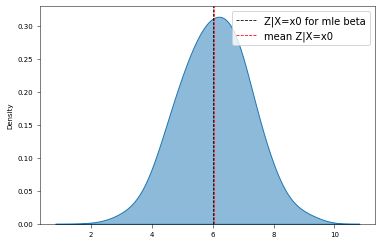

In [25]:
# given X
x0 = 60

# MC simulation
zgx0 = np.zeros( rbeta.size )
for i in range( rbeta.size ):
    zgx0[i] = computationalModel( x0, rbeta[i] )

# Z for MLE beta parameters
zgx0_mle = computationalModel( x0, beta_mode )

# Plot
fig, ax = plt.subplots()
sns.kdeplot( zgx0, fill=True, alpha=0.5, bw_adjust=1.5 )
ax.axvline( zgx0_mle, linestyle='--', color='k', label='Z|X=x0 for mle beta' )
ax.axvline( zgx0.mean(), linestyle='--', color='r', label='mean Z|X=x0' )
ax.legend( fontsize=10 );

Distribution for Z=g(x) by means of standard MC simulations, and represented through uncertainty bounds

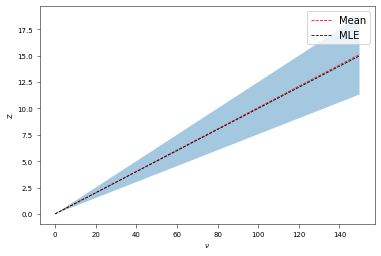

In [26]:
# Probabilistic model
z_given_x = np.zeros( [rbeta.size, len(x_plot)] )
for i in range( rbeta.size ):
        z_given_x[i] = computationalModel( x_plot, rbeta[i] )
z_given_x_mean = z_given_x.mean( axis=0 )
z_given_x_ci = np.quantile( z_given_x, [0.1,0.9], axis=0 )

# MLE model
z_mle = computationalModel( x_plot, beta_mode )

# Plot
fig, ax = plt.subplots()
# ax.plot( q0, y.T, color='gray', alpha=.4 )
ax.fill_between( x_plot, y1=z_given_x_ci[0], y2=z_given_x_ci[1], alpha=.4 )
ax.plot( x_plot, z_given_x_mean, 'r--', label='Mean' )
ax.plot( x_plot, z_mle, 'k--', label='MLE' )
ax.set_xlabel(r'$\nu$')
ax.set_ylabel('Z')
ax.legend( fontsize=10 );

## Hazard model

The hazard is computed convoluting the recurernce model and the flow model Z|X

In [27]:
# range of values for plotting
z_plot = np.arange( 1, 50, 0.01 ) # Z levels
Tr_plot = np.arange(0.2,500,0.1) # Tr values

### 0. Best fit model

Hazard results for MLE parameters for GPD parameters and MAP for beta

In [28]:
# Recurrence rate
m_mle = m_mean
# GPD parameters
t_mle = t_mle
# fLOW model parameters
beta_map = beta_mode

# CDF of flood depths
qi = st.genpareto.rvs( t_mle[0], loc=t_mle[1], scale=t_mle[2], size=500000 ) # discharges
rs = computationalModel( qi+u, beta_map ) # flood depths

# Annual probability of exceedance
rs_mle, Femp = ecdf( rs )

# Return period
Tr_mle = 1/m_mle/(1-Femp)

### 1. Simulation method

Simulate discharge amplitudes from posterior predictive distribution of discharges, and separately simulate mean rates of occurrence. Then simulate flood extent for each. No time stamp is assigned to each event.

1. Sample N model parameters (t,b)
2. For each model parameter set, sample Ncdf discharges
3. For each discharge, sample y for given parameter set
4. Compute empirical F. Compute mean and quantiles

In [29]:
# Simulate model posterior parameters
N = 1000
Ncdf = 100000

# source-to-site parameters
rbeta = dbeta.rvs(size=Ncdf)
# GPD parameters
x_indices = np.random.choice( Xstack.shape[0], size=Ncdf )

# Simulate hazard curve for each parameter set
zGplot = 1-1/Tr_plot/m_mean
Gq1 = np.zeros( [ N, z_plot.size ] )
Gq11 = np.zeros( [ N, z_plot.size ] )
Gq12 = np.zeros( [ N, z_plot.size ] )
zF1 = np.zeros( [ N, zGplot.size ] )
zF11 = np.zeros( [ N, zGplot.size ] )
zF12 = np.zeros( [ N, zGplot.size ] )
rs_sort = np.zeros( [N, Ncdf] )
Tremp = np.zeros( [N, Ncdf] )
for i in range( N ):
    
    t = Xstack[ x_indices[i], : ]
    qi = st.genpareto.rvs( t[0], loc=0, scale=t[1], size=Ncdf )
    rs = computationalModel( qi+u, rbeta[i] )
    # Annual probability of exceedance
    rs_sort, Femp = ecdf( rs )
    Tremp = 1/m_mean/(1-Femp[:-1])
    # Interpolation for plotting
    Gq1[i] = m_mean * np.interp( z_plot, rs_sort, 1-Femp )
    zF1[i]= np.interp( zGplot, Femp, rs_sort )
    
    rs_beta_mle = computationalModel( qi+u, beta_map )
    # Annual probability of exceedance
    rs_sort, Femp = ecdf( rs_beta_mle )
    Tremp = 1/m_mean/(1-Femp[:-1])
    # Interpolation for plotting
    Gq11[i] = m_mean * np.interp( z_plot, rs_sort, 1-Femp )
    zF11[i]= np.interp( zGplot, Femp, rs_sort )
    
    qi_mle = st.genpareto.rvs( size=Ncdf, *t_mle )
    rs_q_mle = computationalModel( qi_mle+u, rbeta[i] )
    # Annual probability of exceedance
    rs_sort, Femp = ecdf( rs_q_mle )
    Tremp = 1/m_mean/(1-Femp[:-1])
    # Interpolation for plotting
    Gq12[i] = m_mean * np.interp( z_plot, rs_sort, 1-Femp )
    zF12[i]= np.interp( zGplot, Femp, rs_sort )

# Mean and confidence bounds
Gq_mean1 = Gq1.mean( axis=0 )
Gq_cf1 = np.quantile( Gq1, [0.1,0.5,0.9], axis=0 )
zF_mean1 = zF1.mean( axis=0 )
zF_cf1 = np.quantile( zF1, [0.1,0.5,0.9], axis=0 )

Gq_mean11 = Gq11.mean( axis=0 )
Gq_cf11 = np.quantile( Gq11, [0.1,0.5,0.9], axis=0 )
zF_mean11 = zF11.mean( axis=0 )
zF_cf11 = np.quantile( zF11, [0.1,0.5,0.9], axis=0 )

Gq_mean12 = Gq12.mean( axis=0 )
Gq_cf12 = np.quantile( Gq12, [0.1,0.5,0.9], axis=0 )
zF_mean12 = zF12.mean( axis=0 )
zF_cf12 = np.quantile( zF12, [0.1,0.5,0.9], axis=0 )

Plots for paper

NameError: name 'rs_plot' is not defined

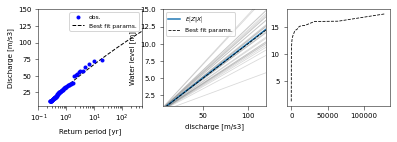

In [33]:
# Plot
fig, ax = plt.subplots( figsize=(16/2.54,4.5/2.54), ncols=3 )

# X MODEL PLOT
ax[0].plot( 1/pannual_emp, np.sort(qu)+u, 'bo', markersize=3, label='obs.', zorder=10 )
# ax[0].plot( Tr_plot, zTri[:,:30], color='gray', alpha=.3 )
# ax[0].plot( Tr_plot, qTr_mean, label='Pred. post.', linewidth=1.5 )
ax[0].plot( 1/pannual_mean_mle, x_plot+u, label='Best fit params.', linewidth=1,
            color='k', linestyle='--' )
ax[0].set_xlabel( 'Return period [yr]' )
ax[0].set_ylabel( 'Discharge [m/s3]' )
ax[0].set_xlim([0.1,500])
ax[0].set_ylim([5,150])
ax[0].set_xscale('log')
ax[0].legend( loc='best', fontsize=6 )
# sns.kdeplot( rbeta[:,0], ax=ax[0])
# ax[0].axvline( beta_max[0], color='k', linestyle='--' )
# ax[0].axvline( rbeta[:,0].mean(), color='r', linestyle='--' )

# 2. Z|X MODEL PLOT
# ax[1].plot( q0, y.T, color='gray', alpha=.4 )
# ax[1].fill_between( qz_plot, y1=y_ci[0], y2=y_ci[1], alpha=.4 )
ax[1].plot( x_plot, z_given_x[:30,:].T, color='gray', alpha=.3 )
ax[1].plot( x_plot, z_given_x_mean, color='C0', label=r'$E \left[ Z|X \right]$', linewidth=1.5 )
ax[1].plot( x_plot, z_mle, 'k--', label='Best fit params.' )
ax[1].set_xlabel('discharge [m/s3]')
ax[1].set_ylabel('Water level [m]')
ax[1].set_xlim([5,120])
ax[1].set_ylim([1,15])
ax[1].legend( fontsize=6 );

# 3. HAZARD PLOT
o1 = ax[2].plot( Tr_mle, rs_mle, label='Best fit params.', color='k', linestyle='--' )
# Method 1.a
# o1 = ax[2].fill_betweenx( x1=1/Gq_cf11[0], x2=1/Gq_cf11[-1], y=rs_plot1, alpha=0.5,
#                         linewidth=0, label='CI: {}\%'.format(90) )
# o2 = ax[2].plot( 1/Gq_mean0, rs_plot0, label='Method 1a' )
o2 = ax[2].plot( 1/Gq_mean11, z_plot, label='Pred. post.', linestyle='-' )
o2 = ax[2].plot( Tr_plot, zF_mean12, label='Pred. post.', linestyle='-', zorder=10, linewidth=1.5 )
# o2 = ax[2].fill_between( zTrplot, y1=zF_cf11[0], y2=zF_cf11[-1], alpha=0.1,
#                          linewidth=1, linestyle='--', label='CI: {}%'.format(90))
# o2 = ax[2].plot( zTrplot, zF_cf11[0], linestyle='-', color='C0', linewidth=1 )
# o2 = ax[2].plot( zTrplot, zF_cf11[-1], linestyle='-', color='C0', linewidth=1 )
o3 = ax[2].plot( Tr_plot, zF12[:30,:].T, color='gray', alpha=.3 )
# o2 = ax[2].plot( 1/Gq_mean02, rs_plot0, label='Method 1a q best', linestyle='--' )

ax[2].set_xlabel( 'Return period [yr]' )
ax[2].set_ylabel( 'Water level [m]' )
ax[2].set_xlim([0.1,500])
ax[2].set_ylim([1,15])
ax[2].set_xscale('log')
ax[2].legend( loc='best', fontsize=6 )
fig.tight_layout();

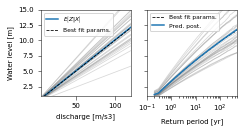

In [31]:
# Plot
fig, ax = plt.subplots( figsize=(8.4/2.54,4.6/2.54), ncols=2, sharey=True )

# 1. Z|X MODEL PLOT
# ax[1].plot( q0, y.T, color='gray', alpha=.4 )
# ax[1].fill_between( qz_plot, y1=y_ci[0], y2=y_ci[1], alpha=.4 )
ax[0].plot( x_plot, z_given_x[:30,:].T, color='gray', alpha=.3 )
ax[0].plot( x_plot, z_given_x_mean, color='C0', label=r'$E \left[ Z|X \right]$', linewidth=1.5 )
ax[0].plot( x_plot, z_mle, 'k--', label='Best fit params.' )
ax[0].set_xlabel('discharge [m/s3]')
ax[0].set_ylabel('Water level [m]')
ax[0].set_xlim([5,120])
ax[0].set_ylim([1,15])
ax[0].legend( fontsize=6 )
# ax[0].legend(loc='upper center', fontsize=6, bbox_to_anchor=(0.5, -0.25), ncol=2)


# 2. HAZARD PLOT
o1 = ax[1].plot( Tr_mle, rs_mle, label='Best fit params.', color='k', linestyle='--' )
# Method 1.a
# o1 = ax[2].fill_betweenx( x1=1/Gq_cf11[0], x2=1/Gq_cf11[-1], y=rs_plot1, alpha=0.5,
#                         linewidth=0, label='CI: {}\%'.format(90) )
# o2 = ax[2].plot( 1/Gq_mean0, rs_plot0, label='Method 1a' )
# o2 = ax[2].plot( 1/Gq_mean11, rs_plot1, label='Pred. post.', linestyle='-' )
o2 = ax[1].plot( Tr_plot, zF_mean12, label='Pred. post.', linestyle='-', zorder=10, linewidth=1.5 )
# o2 = ax[2].fill_between( zTrplot, y1=zF_cf11[0], y2=zF_cf11[-1], alpha=0.1,
#                          linewidth=1, linestyle='--', label='CI: {}%'.format(90))
# o2 = ax[2].plot( zTrplot, zF_cf11[0], linestyle='-', color='C0', linewidth=1 )
# o2 = ax[2].plot( zTrplot, zF_cf11[-1], linestyle='-', color='C0', linewidth=1 )
o3 = ax[1].plot( Tr_plot, zF12[:30,:].T, color='gray', alpha=.3 )
# o2 = ax[2].plot( 1/Gq_mean02, rs_plot0, label='Method 1a q best', linestyle='--' )

ax[1].set_xlabel( 'Return period [yr]' )
# ax[1].set_ylabel( 'Water level [m]' )
ax[1].set_xlim([0.1,500])
ax[1].set_ylim([1,15])
ax[1].set_xscale('log')
ax[1].legend( loc='best', fontsize=6 )
fig.tight_layout();